In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [6]:
class MorphDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        bona_fide_dir = os.path.join(root_dir, 'Bona fide')
        morph_dir = os.path.join(root_dir, 'Morph')

        for label, class_dir in enumerate([bona_fide_dir, morph_dir]):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
train_dataset = MorphDataset(root_dir='/kaggle/input/morph-dataset/Test/Dataset/Train', transform=transform)
val_dataset = MorphDataset(root_dir='/kaggle/input/morph-dataset/Test/Dataset/Validation', transform=transform)
test_dataset = MorphDataset(root_dir='/kaggle/input/morph-dataset/Test/Dataset/Test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from skimage.feature import local_binary_pattern
import numpy as np

def apply_lbp(image):
    image_np = image.cpu().numpy().transpose(0, 2, 3, 1)  # Convert from NCHW to NHWC format
    lbp_images = []
    for img in image_np:
        channels = []
        for i in range(3):  # Apply LBP to each channel independently
            channel = img[:, :, i]
            lbp = local_binary_pattern(channel, P=8, R=1, method="uniform")
            channels.append(lbp)
        lbp_image = np.stack(channels, axis=-1)  # Merge channels back together
        lbp_images.append(lbp_image.transpose(2, 0, 1))  # Convert back to NCHW format
    lbp_images = np.stack(lbp_images)  # Stack to create a batch
    return torch.tensor(lbp_images, dtype=torch.float32).to(image.device)

class UNetXception(nn.Module):
    def __init__(self, num_classes=2):
        super(UNetXception, self).__init__()
        self.encoder = timm.create_model('xception', pretrained=True, features_only=True)
        
        self.upconv1 = nn.ConvTranspose2d(2048, 728, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(1456, 728, kernel_size=3, padding=1)  # 728 + 728
        self.upconv2 = nn.ConvTranspose2d(728, 256, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)   # 256 + 256
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)   # 128 + 128
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)    # 64 + 64
        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, padding=1) # Three channel output to match input channels

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Apply LBP
        lbp_image = apply_lbp(x)

        # Encoder
        enc_outputs = self.encoder(lbp_image)
        enc1, enc2, enc3, enc4, enc5 = enc_outputs[0], enc_outputs[1], enc_outputs[2], enc_outputs[3], enc_outputs[4]

        # Decoder with skip connections
        dec4 = self.upconv1(enc5)             # 728x16x16
        enc4_resized = F.interpolate(enc4, size=dec4.shape[2:], mode='bilinear', align_corners=False)
        dec4 = torch.cat((dec4, enc4_resized), dim=1) # Concatenate with enc4
        dec4 = self.conv1(dec4)               # 728x16x16

        dec3 = self.upconv2(dec4)             # 256x32x32
        enc3_resized = F.interpolate(enc3, size=dec3.shape[2:], mode='bilinear', align_corners=False)
        dec3 = torch.cat((dec3, enc3_resized), dim=1) # Concatenate with enc3
        dec3 = self.conv2(dec3)               # 256x32x32

        dec2 = self.upconv3(dec3)             # 128x64x64
        enc2_resized = F.interpolate(enc2, size=dec2.shape[2:], mode='bilinear', align_corners=False)
        dec2 = torch.cat((dec2, enc2_resized), dim=1) # Concatenate with enc2
        dec2 = self.conv3(dec2)               # 128x64x64

        dec1 = self.upconv4(dec2)             # 64x128x128
        enc1_resized = F.interpolate(enc1, size=dec1.shape[2:], mode='bilinear', align_corners=False)
        dec1 = torch.cat((dec1, enc1_resized), dim=1) # Concatenate with enc1
        dec1 = self.conv4(dec1)               # 64x128x128

        out = self.final_conv(dec1)           # 3x128x128

        # Resize the output to match the input size
        out_resized = F.interpolate(out, size=lbp_image.shape[2:], mode='bilinear', align_corners=False)

        # Residual noise calculation
        residual_noise = lbp_image - out_resized

        # Classify the residual noise
        classification = self.classifier(enc5)

        return out_resized, residual_noise, classification

# Initialize the model and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetXception(num_classes=2).to(device)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


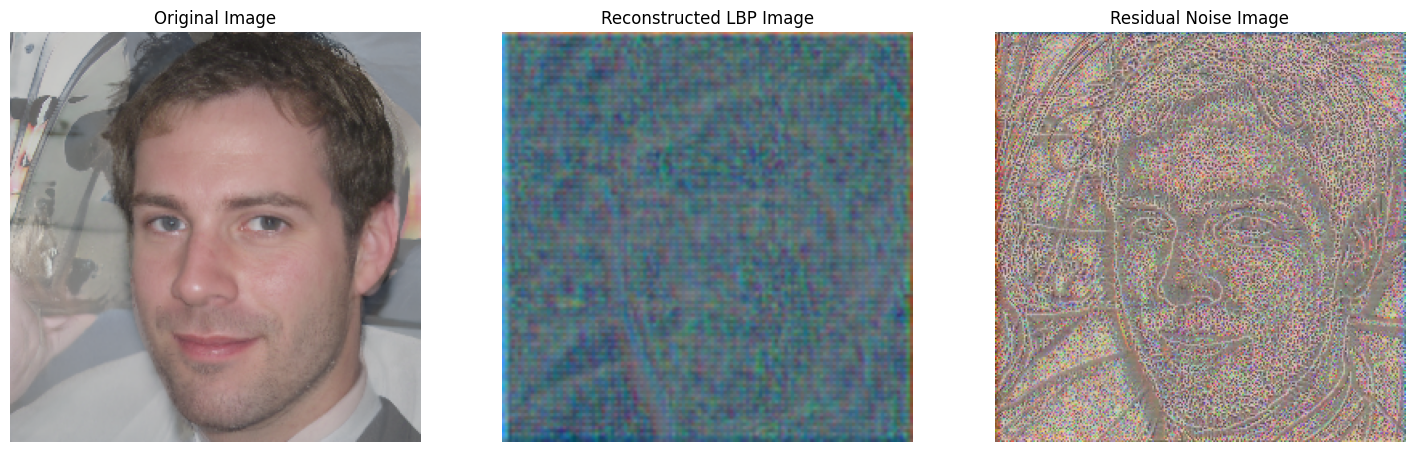

Classification result: tensor([[-0.0609, -0.0673]], device='cuda:0')


In [10]:
import random
import matplotlib.pyplot as plt
from torchvision import transforms

# Select a random image from the train dataset
random_idx = random.randint(0, len(train_dataset) - 1)
image, _ = train_dataset[random_idx]  # We don't need the label here

# Add batch dimension
preprocessed_image = image.unsqueeze(0)

# Initialize the model and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetXception(num_classes=2).to(device)
model.eval()

# Forward pass
with torch.no_grad():
    preprocessed_image = preprocessed_image.to(device)
    reconstructed_image, residual_noise, classification = model(preprocessed_image)

# Denormalize the original image
def denormalize(tensor):
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    return tensor.clamp(0, 1)

# Convert images to PIL format
reconstructed_image = reconstructed_image.squeeze(0).cpu()  # Remove batch dimension and move to CPU
residual_noise = residual_noise.squeeze(0).cpu()  # Remove batch dimension and move to CPU
original_image = denormalize(image)
original_image_pil = transforms.ToPILImage()(original_image)

# Convert LBP images to uint8 format for visualization
def to_uint8(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return (tensor * 255).type(torch.uint8)

reconstructed_image_pil = transforms.ToPILImage()(to_uint8(reconstructed_image))
residual_noise_image_pil = transforms.ToPILImage()(to_uint8(residual_noise))

# Plot the original, reconstructed, and residual noise images
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(original_image_pil)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(reconstructed_image_pil)
axes[1].set_title("Reconstructed LBP Image")
axes[1].axis("off")

axes[2].imshow(residual_noise_image_pil)
axes[2].set_title("Residual Noise Image")
axes[2].axis("off")

plt.show()

# Print the classification result
print("Classification result:", classification)

Starting epoch 1/20


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-11-68a16a6b7003>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training
<ipython-input-11-68a16a6b7003>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Epoch: 1 [0/11200 (0%)]	Loss: 0.172096	Elapsed time: 1.83s
Train Epoch: 1 [160/11200 (1%)]	Loss: 0.150066	Elapsed time: 8.15s
Train Epoch: 1 [320/11200 (3%)]	Loss: 0.109404	Elapsed time: 14.16s
Train Epoch: 1 [480/11200 (4%)]	Loss: 0.099586	Elapsed time: 20.16s
Train Epoch: 1 [640/11200 (6%)]	Loss: 0.050019	Elapsed time: 26.30s
Train Epoch: 1 [800/11200 (7%)]	Loss: 0.038592	Elapsed time: 32.30s
Train Epoch: 1 [960/11200 (9%)]	Loss: 0.004717	Elapsed time: 38.30s
Train Epoch: 1 [1120/11200 (10%)]	Loss: 0.010354	Elapsed time: 44.50s
Train Epoch: 1 [1280/11200 (11%)]	Loss: 0.038303	Elapsed time: 50.65s
Train Epoch: 1 [1440/11200 (13%)]	Loss: 0.052745	Elapsed time: 56.58s
Train Epoch: 1 [1600/11200 (14%)]	Loss: 0.005008	Elapsed time: 62.68s
Train Epoch: 1 [1760/11200 (16%)]	Loss: 0.035050	Elapsed time: 68.67s
Train Epoch: 1 [1920/11200 (17%)]	Loss: 0.035851	Elapsed time: 74.70s
Train Epoch: 1 [2080/11200 (19%)]	Loss: 0.007085	Elapsed time: 80.80s
Train Epoch: 1 [2240/11200 (20%)]	Loss

<ipython-input-11-68a16a6b7003>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation: [0/1600 (0%)]	Loss: 0.067510	Elapsed time: 0.97s
Validation: [160/1600 (10%)]	Loss: 0.080102	Elapsed time: 6.72s
Validation: [320/1600 (20%)]	Loss: 0.192225	Elapsed time: 12.38s
Validation: [480/1600 (30%)]	Loss: 0.037850	Elapsed time: 18.02s
Validation: [640/1600 (40%)]	Loss: 0.005784	Elapsed time: 23.90s
Validation: [800/1600 (50%)]	Loss: 0.008430	Elapsed time: 29.70s
Validation: [960/1600 (60%)]	Loss: 0.029925	Elapsed time: 35.39s
Validation: [1120/1600 (70%)]	Loss: 0.009580	Elapsed time: 41.26s
Validation: [1280/1600 (80%)]	Loss: 0.064332	Elapsed time: 47.09s
Validation: [1440/1600 (90%)]	Loss: 0.033058	Elapsed time: 53.03s
Epoch 1: Train Loss: 0.1271, Train Accuracy: 95.20% | Val Loss: 0.0222, Val Accuracy: 99.00% | Time: 487.71s
Starting epoch 2/20
Train Epoch: 2 [0/11200 (0%)]	Loss: 0.005359	Elapsed time: 0.93s
Train Epoch: 2 [160/11200 (1%)]	Loss: 0.000442	Elapsed time: 7.16s
Train Epoch: 2 [320/11200 (3%)]	Loss: 0.000287	Elapsed time: 13.32s
Train Epoch: 2 [480/112

<ipython-input-11-68a16a6b7003>:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


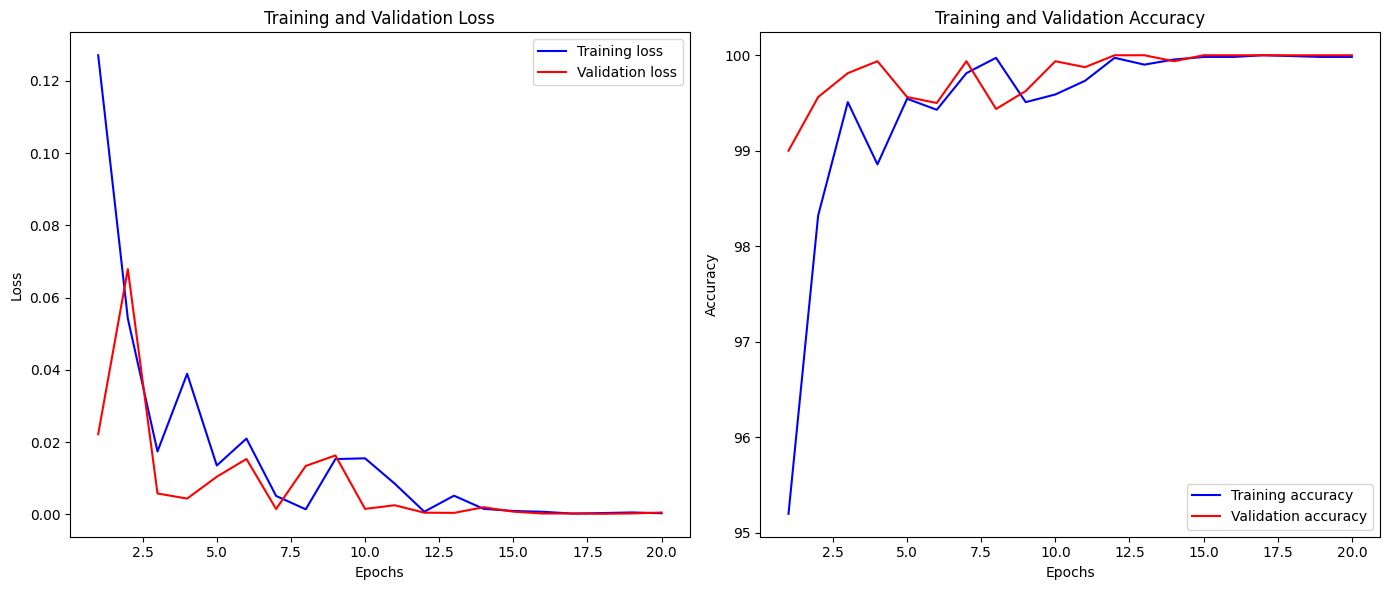

In [11]:
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import accuracy_score
import time

# Initialize the model, loss function, optimizer, and learning rate scheduler
model = UNetXception(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
scaler = GradScaler()  # For mixed precision training

num_epochs = 20  # Reduced for quicker testing
patience = 5  # Early stopping patience reduced
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train(model, device, train_loader, optimizer, epoch, accumulation_steps=4):
    model.train()
    train_loss = 0
    correct = 0

    start_time = time.time()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        with autocast():
            out_resized, residual_noise, output = model(data)
            loss = criterion(output, target)
            loss = loss / accumulation_steps
        
        scaler.scale(loss).backward()
        
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        train_loss += loss.item() * accumulation_steps  # Accumulate loss
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % 10 == 0:
            elapsed = time.time() - start_time
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}\tElapsed time: {elapsed:.2f}s')
        
    train_loss /= len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    
    return train_loss, accuracy

def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0

    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            with autocast():
                out_resized, residual_noise, output = model(data)
                loss = criterion(output, target)
            val_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            if batch_idx % 10 == 0:
                elapsed = time.time() - start_time
                print(f'Validation: [{batch_idx * len(data)}/{len(val_loader.dataset)} '
                      f'({100. * batch_idx / len(val_loader):.0f}%)]\tLoss: {loss.item():.6f}\tElapsed time: {elapsed:.2f}s')

    val_loss /= len(val_loader)
    accuracy = 100. * correct / len(val_loader.dataset)
    
    return val_loss, accuracy

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}/{num_epochs}")
    start_time = time.time()
    
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    val_loss, val_accuracy = validate(model, device, val_loader)
    scheduler.step(val_loss)

    epoch_time = time.time() - start_time

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}% | Time: {epoch_time:.2f}s')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch} epochs.")
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Plotting results
epochs = range(1, len(train_losses) + 1)

# Plot losses
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

import numpy as np
def calculate_bpcer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    false_negatives = cm[0, 1]
    total_genuine = cm[0, 0] + cm[0, 1]
    bpcer = false_negatives / total_genuine
    return bpcer

def calculate_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    return eer, eer_threshold

def calculate_deer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    deer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
    deer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    return deer, deer_threshold
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with autocast():
                _, _, output = model(data)
                loss = criterion(output, target)
            test_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            all_scores.extend(output[:, 1].cpu().numpy())  # Assuming output[:, 1] gives the score for the positive class

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    print(f'Confusion Matrix:\n{cm}')
    
    return test_loss, accuracy, precision, recall, f1, all_labels, all_preds, all_scores

# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall, test_f1, all_labels, all_preds, all_scores = test(model, device, test_loader)

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, '
      f'Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1-Score: {test_f1:.4f}')

# Calculate BPCER
bpcer = calculate_bpcer(all_labels, all_preds)
print(f'BPCER: {bpcer:.4f}')

# Calculate EER
eer, eer_threshold = calculate_eer(all_labels, all_scores)
print(f'EER: {eer:.4f}, EER Threshold: {eer_threshold:.4f}')

# Calculate D-EER
deer, deer_threshold = calculate_deer(all_labels, all_scores)
print(f'D-EER: {deer:.4f}, D-EER Threshold: {deer_threshold:.4f}')

<ipython-input-13-beab6d7d9bed>:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Confusion Matrix:
[[1514   86]
 [   0 1600]]
Test Loss: 0.1864, Test Accuracy: 97.31%, Test Precision: 0.9745, Test Recall: 0.9731, Test F1-Score: 0.9731
BPCER: 0.0537
EER: 0.0138, EER Threshold: 5.0469
D-EER: 0.0138, D-EER Threshold: 5.0469
